In [200]:
import pandas as pd
import numpy as np
import os

# Perimeter

In [239]:
data = pd.read_parquet("../data/edited_data/modeling/data")

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669916 entries, tt0000038 to tt9916764
Data columns (total 19 columns):
averageRating_actors_min          441011 non-null float64
averageRating_actors_median       441011 non-null float64
averageRating_actors_mean         441011 non-null float64
averageRating_actors_max          441011 non-null float64
averageRating_directors_min       147198 non-null float64
averageRating_directors_median    147198 non-null float64
averageRating_directors_mean      147198 non-null float64
averageRating_directors_max       147198 non-null float64
averageRating_genres_min          652487 non-null float64
averageRating_genres_median       652487 non-null float64
averageRating_genres_mean         652487 non-null float64
averageRating_genres_max          652487 non-null float64
ProductionBudget                  4014 non-null float64
primaryTitle                      669562 non-null object
nLetters                          669562 non-null float64
nCapitalLetters 

In [241]:
data = data.drop(columns=["numVotes"], axis=1)

In [242]:
perimeter = data.drop(columns=["ProductionBudget", "primaryTitle"], axis=1).dropna()
#perimeter = data.drop(columns=["primaryTitle"], axis=1).dropna()

La feature "productionBudget" ne permet d'affiner le modèle - en plus de présenter un faible taux de remplissage

### Exploratory analysis

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

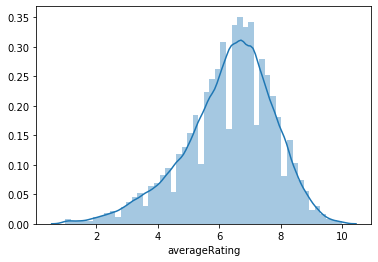

In [244]:
sns.distplot(perimeter.averageRating)

#### correlations

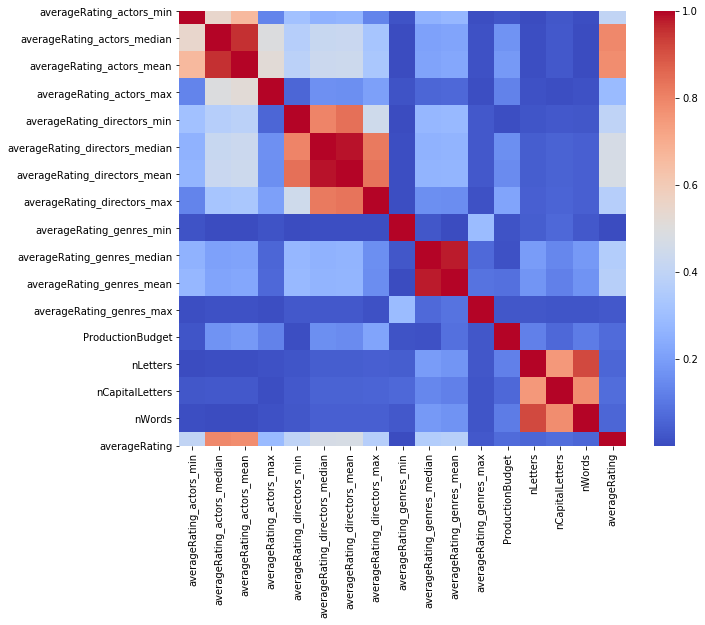

In [245]:
corr = np.abs(data.corr())

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm")

nLetters & nWords sont trop corrélés à la variable nCapitalLetters

In [246]:
perimeter = perimeter.drop(
    columns=[
        "nLetters", 
        "nWords", 
        "averageRating_directors_median", 
        "averageRating_genres_median",
        "averageRating_actors_median"
    ], 
    axis=1)

## modeling

### Linear model

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [248]:
X = perimeter.drop(columns=["averageRating"], axis=1)
y = perimeter.averageRating

In [249]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81474 entries, tt0015268 to tt9916192
Data columns (total 10 columns):
averageRating_actors_min        81474 non-null float64
averageRating_actors_mean       81474 non-null float64
averageRating_actors_max        81474 non-null float64
averageRating_directors_min     81474 non-null float64
averageRating_directors_mean    81474 non-null float64
averageRating_directors_max     81474 non-null float64
averageRating_genres_min        81474 non-null float64
averageRating_genres_mean       81474 non-null float64
averageRating_genres_max        81474 non-null float64
nCapitalLetters                 81474 non-null float64
dtypes: float64(10)
memory usage: 6.8+ MB


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [251]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [252]:
from sklearn.linear_model import LinearRegression

In [253]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [254]:
lr.score(X_test_scaled, y_test)

0.615461295325697

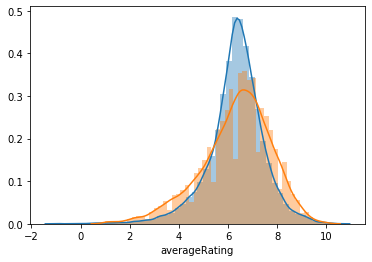

In [255]:
sns.distplot(lr.predict(X_test_scaled))
sns.distplot(y_test)

Tendance à prédire la moyenne...

### Classifier

#### preprocess

In [256]:
m = perimeter.averageRating.mean()
sigma = perimeter.averageRating.std()

def get_rate_classes(rate):
    if rate < m - sigma:
        return 0
    if rate < m:
        return 1
    if rate < m + sigma:
        return 2
    else:
        return 3
    
print(m-sigma, m, m+sigma)


perimeter["target"] = perimeter.averageRating.apply(get_rate_classes)

4.869207870475774 6.318305226207072 7.76740258193837


In [257]:
X = perimeter.drop(columns=["averageRating", "target"], axis=1)
y = perimeter.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

#### modeling

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [259]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3696
           1       0.55      0.34      0.42      7444
           2       0.55      0.84      0.67      9679
           3       0.80      0.42      0.55      3624

    accuracy                           0.59     24443
   macro avg       0.65      0.55      0.57     24443
weighted avg       0.61      0.59      0.57     24443



In [260]:
clf = RandomForestClassifier()
param_grid = {
    'max_depth': [10],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2)

grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=10, n_estimators=100 ..................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=10, n_estimators=100, total=   3.0s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=100, total=   2.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   2.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [261]:
y_pred = grid.predict(X_test_scaled)

In [262]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.58      0.65      3696
           1       0.55      0.56      0.55      7444
           2       0.61      0.76      0.68      9679
           3       0.83      0.46      0.59      3624

    accuracy                           0.63     24443
   macro avg       0.68      0.59      0.62     24443
weighted avg       0.64      0.63      0.62     24443



In [263]:
pd.crosstab(y_test, grid.predict(X_test_scaled))

col_0,0,1,2,3
target,,,,
0,2148,1288,260,0
1,646,4149,2618,31
2,153,1897,7319,310
3,16,207,1736,1665


In [264]:
contributions = dict(zip(X_train.columns.tolist(), grid.best_estimator_.feature_importances_))
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
averageRating_actors_mean,0.543101
averageRating_actors_min,0.157658
averageRating_actors_max,0.087023
averageRating_directors_mean,0.085894
averageRating_genres_mean,0.062317
averageRating_directors_min,0.031296
averageRating_directors_max,0.027289
nCapitalLetters,0.004721
averageRating_genres_max,0.000438
averageRating_genres_min,0.000264
